# Hyperbolic Secant Mixture modelの推定
+ モデル:
    + $p(x|w) = \sum_{k=1}^K a_k \frac{\sqrt{s_k}}{2} \frac{1}{\cosh(\frac{s_k}{2}(x - b_k))}$
    + $x, b_k \in \mathbb{R}, s_k \in \mathbb{R}_+$
+ 事前分布:
    + $\varphi(w) = Dir(a|\{ \alpha_k \}_{k=1}^K) \prod_{k=1}^K N(b_k|0, (s_k \beta_k)^{-1} ) Gam(s_k|\gamma_k, \delta_k)$
+ アルゴリズム
   1. 以下の初期化を行う:
       + $g_{ik}(\eta), v_{ik}(\eta), h_{ik}(\xi), u_{ik}(\xi)$
   2. 以下を計算する
       + $\hat{\alpha}_k = \alpha_k + \sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\beta}_k = \beta_k + \sum_{i=1}^n -2v_{ik}(\eta)$
       + $\hat{m}_k = \frac{1}{\hat{\beta}_k} \sum_{i=1}^n -2v_{ik}(\eta)x_i$
       + $\hat{\gamma}_k = \gamma_k + \frac{1}{2}\sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\delta}_k = \delta_k + \sum_{i=1}^n -v_{ik}(\eta)x_i^2 - \frac{\hat{\beta}_k}{2}\hat{m}_k^2$
   3. 以下を計算する
       + $g_{ik}(\eta) = \frac{\hat{\gamma}_k}{\hat{\delta}_k} (x_i - \hat{m}_k)^2 + \frac{1}{\hat{\beta}_k}$
       + $v_{ik}(\eta) = -u_{ik}(\xi)\frac{ \tanh(\sqrt{g_{ik}(\eta)}/2) }{4\sqrt{g_{ik}(\eta)}}$
   4. 以下を計算する
       + $h_{ik}(\xi) = \psi(\hat{\alpha}_k) - \psi(\sum_{l=1}^K \hat{\alpha}_l) + \frac{1}{2}(\psi(\hat{\gamma}_k) - \log(\hat{\delta}_k)) - \log(\cosh(\sqrt{g_{ik}(\eta)}/2)) $
       + $u_{ik}(\xi) = \frac{ \exp(h_{ik}(\xi)) }{ \sum_{l=1}^K \exp(h_{il}(\xi)) }$
       + ここで,$\psi(x) = \frac{d}{dx}\log \Gamma(x)$
   5. 2.に戻る
   
+ 評価関数$\overline{F}_{\xi, \eta}(x^n)$の値
    + $\overline{F}_{\xi, \eta}(x^n) = - \phi(h(\xi)) - \psi(g(\eta)) + u(\xi) \cdot h(\xi) + v(\eta) \cdot g(\eta) $  
        $+ n \log 2 \pi + \log \Gamma(\sum_{l = 1}^K \hat{\alpha}_l) - \log \Gamma({\sum_{l = 1}^K\alpha}_l) + \sum_{k=1}^K \log \frac{\Gamma(\alpha_k)}{\Gamma(\hat{\alpha}_k)}$  
        $+ \sum_{k=1}^K \bigl\{ \frac{1}{2} \log \frac{\hat{\beta}_k}{\beta_k} + \hat{\gamma}_k \log \hat{\delta}_k - \gamma_k \log \delta_k - \log \Gamma(\hat{\gamma}_k) + \log \Gamma(\gamma_k) \bigr\}$

In [34]:
%matplotlib inline

In [35]:
import numpy as np
from scipy.special import gammaln, psi
import matplotlib.pyplot as plt
import seaborn as sns

## HSMMに従う確率変数を生成する

In [36]:
data_seed = 20190505
n = 1000
true_ratio = np.array([0.5, 0.5])
true_s = np.array([4, 0.5])
true_b = np.array([4, -4])
np.random.seed(data_seed)

In [37]:
true_label = np.random.multinomial(n = 1, pvals = true_ratio, size = n)
true_label_arg = np.argmax(true_label, axis = 1)

In [38]:
def random_hsm(n, loc = 0, scale = 1):
    """
    hyperbolic secant distributionに従う確率変数を生成する
    $Y \sim standard_cauchy(x)$の時,  
    $X = \frac{2}{s}\sinh^{-1}(Y) + b$は,  
    $X \sim p(x) = \frac{s}{2\pi}\frac{1}{\cosh(s(x-b)/2)}$に従うはずなので、その確認を行う
    """
    Y = np.random.standard_cauchy(size=n)
    X = 2/np.sqrt(scale)*np.arcsinh(Y) + loc    
    return X

In [39]:
x = np.zeros(n)
for i in range(n):
    x[i] = random_hsm(n=1, loc=true_b[true_label_arg[i]], scale=true_s[true_label_arg[i]])

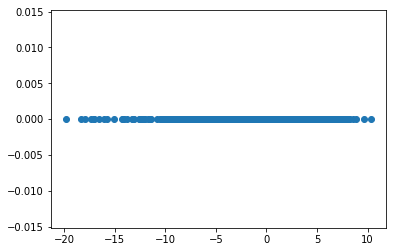

In [40]:
plt.scatter(x,np.zeros(n))

(array([  6.,   8.,  15.,  54., 142., 160.,  95., 319., 181.,  20.]),
 array([-19.75950248, -16.7542915 , -13.74908052, -10.74386954,
         -7.73865857,  -4.73344759,  -1.72823661,   1.27697436,
          4.28218534,   7.28739632,  10.2926073 ]),
 <a list of 10 Patch objects>)

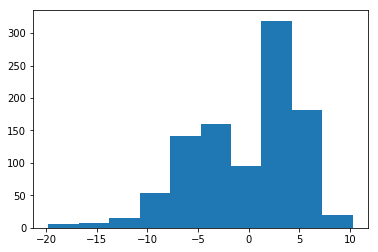

In [41]:
plt.hist(x)

(array([  6.,   6.,  16.,  33., 103., 164.,  99.,  47.,  18.,   8.]),
 array([-19.75950248, -16.92921626, -14.09893004, -11.26864382,
         -8.43835761,  -5.60807139,  -2.77778517,   0.05250105,
          2.88278726,   5.71307348,   8.5433597 ]),
 <a list of 10 Patch objects>)

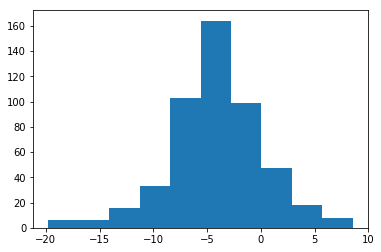

In [42]:
plt.hist(x[np.where(true_label_arg == 1)])

(array([  5.,  20.,  42., 125., 176.,  90.,  21.,  15.,   4.,   2.]),
 array([-0.96094147,  0.16441341,  1.28976828,  2.41512316,  3.54047804,
         4.66583291,  5.79118779,  6.91654267,  8.04189754,  9.16725242,
        10.2926073 ]),
 <a list of 10 Patch objects>)

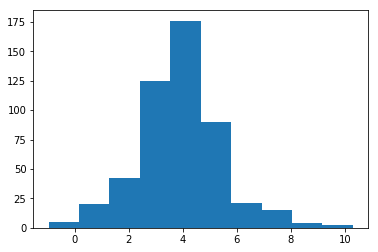

In [43]:
plt.hist(x[np.where(true_label_arg == 0)])

# 学習を行う

In [44]:
### 初期設定を行う
iteration = 1000
learning_seed = 20190510

## 学習モデルのコンポーネントの数
K = 3

## ハイパーパラメータ
pri_alpha = 3
pri_beta = 0.001
pri_gamma = 2
pri_delta = 2

np.random.seed(learning_seed)

energy = np.zeros(iteration)

In [45]:
### 初期値の設定
est_h_xi = np.random.gamma(shape = 1, size = (n, K))
est_u_xi = np.exp(est_h_xi) / np.repeat(np.exp(est_h_xi).sum(axis = 1), K).reshape(n,K)
# est_u_xi = np.random.dirichlet(alpha = np.ones(K), size=n)

est_g_eta = np.abs(np.random.normal(size=(n,K)))
est_v_eta = - est_u_xi * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))

In [46]:
### 繰り返し計算部分
for ite in range(iteration):
    ### 事後分布の更新
    est_alpha = pri_alpha + est_u_xi.sum(axis = 0)
    est_beta = pri_beta + (-2*est_v_eta.sum(axis = 0))
    est_m = (-2*x @ est_v_eta)/est_beta
    est_gamma = pri_gamma + est_u_xi.sum(axis = 0)/2
    est_delta = pri_delta - (x**2) @ est_v_eta - est_beta / 2 * est_m**2
    ### 対数双曲線関数の更新
    est_g_eta = est_gamma / est_delta * (np.repeat(x,K).reshape(n,K) - np.repeat(est_m,n).reshape(K,n).T)**2 + 1/est_beta
    est_v_eta = - est_u_xi * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))
    
    ### 隠れ変数の更新
    est_h_xi = np.repeat(psi(est_alpha) - psi(est_alpha.sum()) + (psi(est_gamma) - np.log(est_delta))/2, n).reshape(K,n).T - np.log(np.cosh(np.sqrt(est_g_eta)/2))
    max_h_xi = est_h_xi.max(axis = 1)
    norm_h_xi = est_h_xi - np.repeat(max_h_xi,K).reshape(n,K)
    est_u_xi = np.exp(norm_h_xi) / np.repeat(np.exp(norm_h_xi).sum(axis = 1), K).reshape(n,K)

    ### エネルギーの計算
    energy[ite] = (est_u_xi * np.log(np.cosh(np.sqrt(est_g_eta)/2))).sum() - (np.log(np.exp(norm_h_xi).sum(axis = 1)) + max_h_xi).sum() + (est_u_xi * est_h_xi + est_v_eta * est_g_eta).sum()
    energy[ite] += gammaln(est_alpha.sum()) - gammaln(K*pri_alpha) + (-gammaln(est_alpha) + gammaln(pri_alpha)).sum()
    energy[ite] += (np.log(est_beta/pri_beta)/2 + est_gamma * np.log(est_delta) - pri_gamma * np.log(pri_delta) - gammaln(est_gamma) + gammaln(pri_gamma)).sum()
    print(energy[ite])

1532.1450040207424
1371.7574986270945
1326.1516123322049
1310.4280580713494
1304.6676308027768
1302.2053889194976
1301.246704471688
1300.6361522078937
1300.3491425568563
1299.945150388044
1299.5900744105707
1298.9695285277628
1298.2102354662493
1297.0021580997682
1295.360815213856
1292.8976614049254
1289.3954434470033
1284.110247329182
1275.9303665430114
1262.4720092976763
1240.6167363091363
1208.7284986187979
1170.28311254537
1132.5764008728067
1101.5207623572528
1078.946976288481
1063.7898779354687
1054.04833323016
1047.9083616513733
1044.047244305505
1041.5938526341474
1040.0017879171673
1038.9372411458135
1038.1983895229946
1037.6637078959327
1037.2597683854176
1036.941939160397
1036.6827686635731
1036.4651304820345
1036.2781167328958
1036.1146114104727
1035.9698271479722
1035.8404330837002
1035.724022219294
1035.6187892657326
1035.523329980064
1035.4365169104867
1035.357419614789
1035.2852533760672
1035.219344752818
1035.1591081960237
1035.1040293798906
1035.0536531073496
1035.007

In [47]:
{
    "est_ratio": est_alpha / est_alpha.sum(),
    "est_b": est_m,
    "est_s": est_gamma / est_delta
}

{'est_ratio': array([9.99700090e-05, 5.17822406e-01, 4.82077624e-01]),
 'est_b': array([-5.32450802e-10,  3.84814396e+00, -4.36122600e+00]),
 'est_s': array([1.        , 3.80095553, 0.58475217])}